<a href="https://colab.research.google.com/github/langemittbacken/D7047E_labs/blob/main/lab4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {'cuda' if torch.cuda.is_available() else 'cpu'}")

Using cuda


In [ ]:
import unidecode
import string
import random
import re

batch_size = 16
chunk_len = 20
n_epochs = 2000
model = "gru"
learning_rate = 0.01
n_layers = 2
hidden_size = 100
print_every = 100
#shuffle = 

filename = read_file('/content/shakespear.txt')

file = unidecode.unidecode(open('/content/shakespear.txt').read())
file_len = len(file)
print('file_len =', file_len)



file_len = 1115394


In [ ]:
import re

file2 = unidecode.unidecode(open('/content/shakespear.txt').read())

filtered_file = re.sub(r"[^a-zA-Z\s]", "", file2)

wordsex = filtered_file.split()
print(len(wordsex))
#print(filtered_file)
vocab=[]
for word in wordsex:
  word = word.lower()
  if word not in vocab:
      vocab.append(word)

def getChunk(i):
  chunk = []
# Extract 20 consecutive words starting from the random index
  chunk = wordsex[i:i+chunk_len + 1]
  return chunk
chunk = getChunk(20)
print(len(chunk))

202619
21


In [ ]:
import unidecode
import string
import random
import time
import math
import torch

# Reading and un-unicode-encoding data

def read_file(filename):
    file = unidecode.unidecode(open(filename).read())
    return file, len(file)

# Turning a string into a tensor

def word_tensor(string):
    words = string
    tensor = torch.zeros(len(words)).long()
    for c in range(len(string)):
        try:
            tensor[c] = vocab.index(words[c].lower())
        except:
            continue
    return tensor

# Readable time elapsed

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
word_tensor("this this")

this
this


tensor([96, 96])

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable


class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model="gru", n_layers=1):
        super(CharRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def forward2(self, input, hidden):
        encoded = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(encoded.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

In [ ]:
import torch
import os
import argparse

def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=False):
    words = prime_str.split()

    hidden = decoder.init_hidden(1)
    prime_input = Variable(word_tensor(prime_str).unsqueeze(0))
    if cuda:
        hidden = hidden.to(device)
        prime_input = prime_input.to(device)
    predicted = prime_str
    
    
    # Use priming string to "build up" hidden state
    for p in range(len(words) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)
        
    inp = prime_input[:,-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        top_index= top_i.item()
        # Add predicted character to string and use as next input
        predicted_char = vocab[top_index]
        predicted += " " + predicted_char 
        inp = torch.tensor([top_index])
        if cuda:
            inp = inp.to(device)

    return predicted


In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import argparse
import os

from tqdm import tqdm



# Parse command line arguments


def random_training_set(chunk_len, batch_size):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    for bi in range(batch_size):
        start_index = random.randint(0, len(wordsex) - chunk_len)
        #end_index = start_index + chunk_len + 1
        chunk = getChunk(start_index)
        inp[bi] = word_tensor(chunk[:-1])
        target[bi] = word_tensor(chunk[1:])
    inp = Variable(inp)
    target = Variable(target)
    
    if(torch.cuda.is_available()):
      inp = inp.to(device)
      target = target.to(device)
      
    return inp, target

def train(inp, target):
    hidden = decoder.init_hidden(batch_size)
    if(torch.cuda.is_available()):
      hidden = hidden.to(device)
      #inp = inp.to(device)
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(batch_size, -1), target[:,c])
        
    loss.backward()
    decoder_optimizer.step()
    return loss.data.item() / chunk_len



# Initialize models and start training

decoder = CharRNN(
    len(vocab),
    hidden_size,
    len(vocab),
    model=model,
    n_layers=n_layers,
)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
if(torch.cuda.is_available()):
  decoder = decoder.to(device)

perplex = []
start = time.time()
all_losses = []
loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in tqdm(range(1, n_epochs + 1)):
      loss = train(*random_training_set(chunk_len, batch_size))
      loss_avg += loss
      perplex.append(math.exp(loss))
      if epoch % print_every == 0:
          print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
          #print(generate(decoder, 'Wh', 100, True), '\n')



Training for 2000 epochs...


  5%|▌         | 105/2000 [00:03<01:10, 27.01it/s]

 3s (100 5%) 7.0965]


 10%|█         | 203/2000 [00:07<01:37, 18.44it/s]

 7s (200 10%) 6.9963]


 15%|█▌        | 305/2000 [00:12<01:03, 26.79it/s]

 12s (300 15%) 6.7483]


 20%|██        | 404/2000 [00:16<00:58, 27.22it/s]

 16s (400 20%) 6.9616]


 25%|██▌       | 503/2000 [00:19<00:54, 27.35it/s]

 19s (500 25%) 6.9022]


 30%|███       | 605/2000 [00:24<00:52, 26.50it/s]

 24s (600 30%) 7.0700]


 35%|███▌      | 704/2000 [00:28<00:45, 28.22it/s]

 28s (700 35%) 6.8208]


 40%|████      | 803/2000 [00:32<00:44, 26.76it/s]

 31s (800 40%) 6.8241]


 45%|████▌     | 903/2000 [00:36<01:01, 17.84it/s]

 36s (900 45%) 6.8041]


 50%|█████     | 1003/2000 [00:40<00:37, 26.79it/s]

 40s (1000 50%) 6.8495]


 55%|█████▌    | 1105/2000 [00:44<00:32, 27.18it/s]

 44s (1100 55%) 6.5849]


 60%|██████    | 1202/2000 [00:48<00:42, 18.83it/s]

 48s (1200 60%) 6.7286]


 65%|██████▌   | 1303/2000 [00:52<00:25, 27.22it/s]

 52s (1300 65%) 6.8980]


 70%|███████   | 1405/2000 [00:57<00:22, 26.24it/s]

 57s (1400 70%) 6.7446]


 75%|███████▌  | 1501/2000 [01:01<00:22, 22.36it/s]

 1s (1500 75%) 6.6502]


 80%|████████  | 1603/2000 [01:06<00:14, 27.26it/s]

 5s (1600 80%) 6.5877]


 85%|████████▌ | 1705/2000 [01:09<00:11, 26.64it/s]

 9s (1700 85%) 6.6850]


 90%|█████████ | 1805/2000 [01:13<00:07, 27.61it/s]

 13s (1800 90%) 6.5401]


 95%|█████████▌| 1905/2000 [01:18<00:03, 24.78it/s]

 18s (1900 95%) 6.7630]


100%|██████████| 2000/2000 [01:21<00:00, 24.45it/s]

 21s (2000 100%) 6.2083]


Task2

In [ ]:
print(generate(decoder, 'which is', 20, cuda = True), '\n')

which is more she the moon and it the own blast lawful much slain what something i of the air he who 



In [ ]:
len(vocab)

12847

Task 3

In [ ]:
print(generate(decoder, 'The', 100, cuda = True), '\n')
print(generate(decoder, 'Which is', 100, cuda = True), '\n')
print(generate(decoder, 'blah blah blah', 100, cuda = True), '\n')
print(generate(decoder, '.', 100, cuda = True), '\n')

The words romeo the duke for we and see me that our gentleman richard sir he and you away my lord me as thus lawful we to done sir might and comes the wits ill my king with the lord in by my lord gentle he my men i thou so ill an fearful very holy house henry that and be that his sister so horrible him that in to me to his treasons to bolingbroke i our is love and the instruction not made out and merry to queen an learn her label what this of whose prevention clarence you 

Which is ignorance and sir with pity my world my officer mariana be the violent good time thou the jest and this cannot didst are friend i they the requited if places thou be the crown little but an good cannot dream this openly satisfy archidamus of his princely but soft ralph here tomorrow that it knife worship of she speak of the sun and ill privately am what with i thee the eyes tis it friar thing the coxcomb it as must my kin to the new whom that i yet side they turn with way should your lord the news 

blah bl

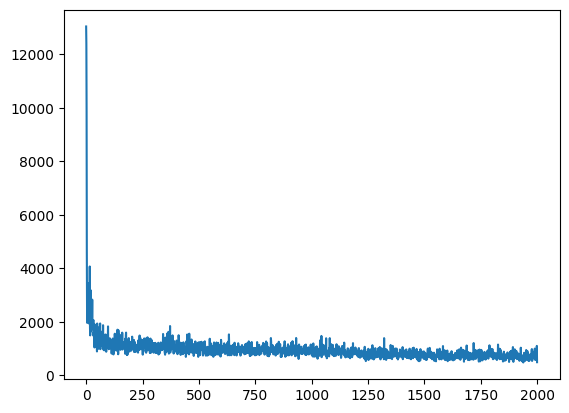

In [ ]:


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline


plt.figure()
plt.plot(perplex)



In [ ]:
perplex

[101.58414310592902, 65.32600910804842]